# SI 618: Data Manipulation and Analysis
## 06 - Categorical Data & Text Processing 
### Pivoting, contingency tables, crosstabs, mosaic plots and chi-squared

### Dr. Chris Teplovs, School of Information, University of Michigan
<small><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a> This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


## Overview for today
* Review HW1
* Project proposal review 
* Categorical Data: contingency tables, crosstabs, mosaic plots, chi-squared
* Text Processing: regular expressions

uniqname: kaikang

## Q0: What did you find confusing from last class?

How to create multiple histograms ( > 2 and not overlapped ) using one function?

# Categorical Data

## Contingency tables, crosstabs, and chi-square

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

Let's generate a data frame to play with:

In [3]:
df = pd.DataFrame({'color' : ['red', 'green', 'green', 'black'] * 6,
                   'make' : ['ford', 'toyota', 'dodge'] * 8,
                   'vehicleClass' : ['suv', 'suv', 'suv', 'car', 'car', 'truck'] * 4})

In [6]:
df.head()

color    make vehicleClass
0    red    ford          suv
1  green  toyota          suv
2  green   dodge          suv
3  black    ford          car
4    red  toyota          car

One of the most basic transformations we can do is a crosstab:

In [7]:
ct = pd.crosstab(df.color,df.vehicleClass)
ct

vehicleClass  car  suv  truck
color                        
black           2    2      2
green           4    6      2
red             2    4      0

Notice how similar it is to pivoting.  In fact, go ahead and use ```pivot_table``` to do the same sort of transformation:

### <font color="magenta">Q1: Use ```pivot_table``` to create a DataFrame similar to the one from the ```crosstab``` above:

In [9]:
pd.pivot_table(data=df, columns='vehicleClass', index='color', aggfunc=len)

make           
vehicleClass  car  suv truck
color                       
black         2.0  2.0   2.0
green         4.0  6.0   2.0
red           2.0  4.0   NaN

As usual, we would like to visualize our results:

In [10]:
import seaborn as sns

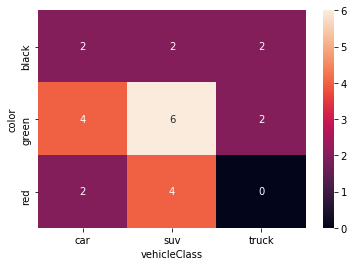

In [11]:
sns.heatmap(ct,annot=True)

### Titanic data

One of the more popular datasets that we use for experimenting with crosstabs is the 
survivor data from the Titanic disaster:

In [12]:
titanic = pd.read_csv('data/titanic.csv')

Let's create a crosstab of the data:

In [13]:
ct = pd.crosstab(titanic.passtype,titanic.status,margins=True)
ct

status    alive  dead   All
passtype                   
crew        212   673   885
first       203   122   325
second      118   167   285
third       178   528   706
All         711  1490  2201

Now let's use our knowledge of data manipulation with pandas to generate some percentages totals:

### <font color="magenta">Q2: Generate this:</font>

![](assets/samplect.png)

In [23]:
pd.crosstab(titanic.passtype,titanic.status,margins=True).apply(lambda r: 2 * r * 100/r.sum(), axis=1)

status        alive       dead    All
passtype                             
crew      23.954802  76.045198  100.0
first     62.461538  37.538462  100.0
second    41.403509  58.596491  100.0
third     25.212465  74.787535  100.0
All       32.303498  67.696502  100.0

In [27]:
ctExt = ct.copy()
ctExt.sum(axis=1)

passtype
crew      1770
first      650
second     570
third     1412
All       4402
dtype: int64

In [29]:
ctExt['total'] = ctExt.sum(axis=1)

### <font color="magenta">Q3: Is this what we would have expected?</font>

In [30]:
# fill in the correct numbers on the next two lines (where np.NaN is right now)
expectedAlive = ctExt.total * .323
expectedDead = ctExt.total * .677

### Now generate a similar matrix for the *expected* (as oppposed to observed) values:

In [31]:
ctExpected = ct.copy()
ctExpected.alive = expectedAlive
ctExpected.dead = expectedDead
ctExpected['total'] = ctExpected.sum(axis=1)
ctExpected.loc['total'] = ctExpected.sum(axis=0)
alivePercent = np.round(ctExpected.alive/ctExpected.total * 100,decimals=2)
deadPercent = np.round(ctExpected.dead/ctExpected.total * 100,decimals=2)
totalPercent = np.round(ctExpected.total/ctExpected.total * 100,decimals=2)
detailExp = ctExpected.copy()
detailExp.alive = ctExpected.alive.astype('str') + " (" + alivePercent.astype('str') + "%)"
detailExp.dead = ctExpected.dead.astype('str') + " (" + deadPercent.astype('str') + "%)"
detailExp.total = ctExpected.total.astype('str') + " (" + totalPercent.astype('str') + "%)"

In [32]:
detailExp

status                          alive                         dead     All  \
passtype                                                                     
crew                  571.71 (21.53%)  1198.2900000000002 (45.13%)   885.0   
first     209.95000000000002 (21.53%)              440.05 (45.13%)   325.0   
second                184.11 (21.53%)  385.89000000000004 (45.13%)   285.0   
third                456.076 (21.53%)   955.9240000000001 (45.13%)   706.0   
All                 1421.846 (21.53%)            2980.154 (45.13%)  2201.0   
total               2843.692 (21.53%)   5960.308000000001 (45.13%)  4402.0   

status               total  
passtype                    
crew       2655.0 (100.0%)  
first       975.0 (100.0%)  
second      855.0 (100.0%)  
third      2118.0 (100.0%)  
All        6603.0 (100.0%)  
total     13206.0 (100.0%)

In [33]:
detailCT

NameError: name 'detailCT' is not defined

So, there we have the expected and observed values, along with their proportions.

In addition to the heatmap shown above, we can use a mosaic plot to visualize 
contingency tables:

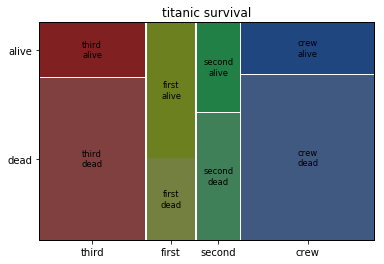

In [34]:
from statsmodels.graphics.mosaicplot import mosaic
t = mosaic(titanic, ['passtype','status'],title='titanic survival')

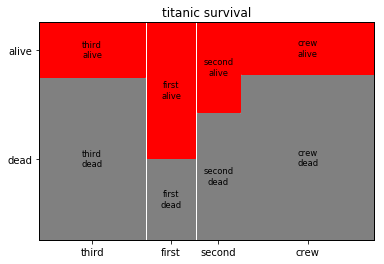

In [35]:
# slightly easier to read
props = lambda key: {'color': 'r' if 'alive' in key else 'gray'}
t = mosaic(titanic, ['passtype','status'],title='titanic survival',properties=props)

Finally, we can go beyond visual exploration and apply analytic tests to see if the 
observed values differ from the expected ones.  The chi-square test sums the squares of the differences
between the observed and expected values, normalized for the expected values.

## Let's talk about $\chi^2$

In [37]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex)

chi2 =  190.40110361683327
p-val =  6.705773035354302e-37
degree of freedom =  8
Expected:


0            1       2
0  285.885961   599.114039   885.0
1  104.986370   220.013630   325.0
2   92.064970   192.935030   285.0
3  228.062699   477.937301   706.0
4  711.000000  1490.000000  2201.0

## Let's apply these ideas to another dataset

For this component, we'll use the Comic Characters data set:

In [40]:
comic_characters = pd.read_csv("data/comic_characters.csv", index_col="id")
comic_characters.head(1)

publisher                       name         Identity            align  \
id                                                                          
1     Marvel  Spider-Man (Peter Parker)  Secret Identity  Good Characters   

           eye        hair              sex              alive  appearances  \
id                                                                            
1   Hazel Eyes  Brown Hair  Male Characters  Living Characters       4043.0   

   first_appearance   month    year      date  
id                                             
1      1962, August  August  1962.0  8/1/1962

In [44]:
comic_characters.groupby(['Identity','publisher'])['appearances'].mean()

Identity                       publisher
Identity Unknown               DC            3.000000
Known to Authorities Identity  Marvel       74.400000
No Dual Identity               Marvel       24.402013
Public Identity                DC           28.287166
                               Marvel       23.407615
Secret Identity                DC           32.655157
                               Marvel       17.379794
Name: appearances, dtype: float64

### Example

We'd like to know which publisher uses different 'identity' types for their characters? Have DC characters appeared more publicly? What is the average number of times Marvel Characters appeared known to authorities identity?

In [41]:
comic_characters.groupby(['Identity','publisher'])['appearances'].mean().unstack().fillna(0)

publisher                             DC     Marvel
Identity                                           
Identity Unknown                3.000000   0.000000
Known to Authorities Identity   0.000000  74.400000
No Dual Identity                0.000000  24.402013
Public Identity                28.287166  23.407615
Secret Identity                32.655157  17.379794

Alternatively, we can use .pivot_table(). For example:

In [42]:
avg_appearance_per_identity = comic_characters.pivot_table(index='Identity', 
                                                          columns='publisher', 
                                                          values='appearances',
                                                          aggfunc='mean')
avg_appearance_per_identity.fillna(0).head()

publisher                             DC     Marvel
Identity                                           
Identity Unknown                3.000000   0.000000
Known to Authorities Identity   0.000000  74.400000
No Dual Identity                0.000000  24.402013
Public Identity                28.287166  23.407615
Secret Identity                32.655157  17.379794

For .pivot_table(), you need to specify these four arguments:
1. index: the field that will become the index of the output table
2. columns: the field that will become the columns of the output table
3. values: the field to be aggregated/summarized
4. aggfunc: the aggregation operator applied to values, if there are more than 1 entry corresponding to each (index, column) pair, such as "mean", "count", "max"
    

### Let's warm up with a few groupby and pivot_table exercises:

### <font color="magenta">Q4: What is the total number of appearances of characters for each publisher?

In [46]:
a = comic_characters.groupby('publisher')[['appearances']].sum()
a.head()

appearances
publisher             
DC            154532.0
Marvel        260270.0

### <font color="magenta">Q5: What is the total number of appearances of characters by each publisher in each year? Output a table.

In [55]:
b = comic_characters.groupby(['year','publisher']).sum().fillna(0)
b.head()
b.loc[1976.0]

appearances
publisher             
DC              1757.0
Marvel          6433.0

In [51]:
b2 = comic_characters.groupby(['publisher','year']).sum().fillna(0)
b2.head()

appearances
publisher year               
DC        1935.0        125.0
          1936.0        240.0
          1937.0        458.0
          1938.0       1639.0
          1939.0       4067.0

### <font color="magenta">Q6: Construct a contingency table of sex and character alignment normalized by all values.

Display the normalized values in percentage (%) format. Use brief sentences to explain your findings.  

Hint: use "normalize=all" in your crosstab statement.  What does normalize do? (read the docs)

In [56]:
comic_characters.columns

Index(['publisher', 'name', 'Identity', 'align', 'eye', 'hair', 'sex', 'alive',
       'appearances', 'first_appearance', 'month', 'year', 'date'],
      dtype='object')

In [63]:
ct = pd.crosstab(comic_characters.sex, comic_characters['align'], normalize=False)
ct

align                   Bad Characters  Good Characters  Neutral Characters  \
sex                                                                           
Agender Characters                  20               10                  13   
Female Characters                 1573             2490                 836   
Genderfluid Characters               0                1                   1   
Genderless Characters               11                6                   3   
Male Characters                   7561             4809                1799   
Transgender Characters               1                0                   0   

align                   Reformed Criminals  
sex                                         
Agender Characters                       0  
Female Characters                        1  
Genderfluid Characters                   0  
Genderless Characters                    0  
Male Characters                          2  
Transgender Characters                   0

### <font color="magenta">Q7: Create a mosaic plot of character alignment and alive status.

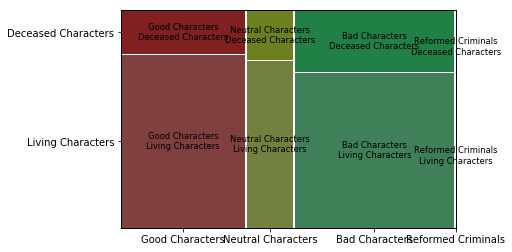

In [64]:
t = mosaic(comic_characters, ['align','alive'])

In [70]:
ct = pd.crosstab(comic_characters.alive, comic_characters['align'], normalize=False)
ct

align                Bad Characters  Good Characters  Neutral Characters  \
alive                                                                      
Deceased Characters            2732             1513                 635   
Living Characters              6882             5954                2138   

align                Reformed Criminals  
alive                                    
Deceased Characters                   1  
Living Characters                     2

### <font color="magenta">Q8: Conduct a $\chi^2$ test of ```align``` and ```alive```. Please specify your (null and alternative) hypotheses and explain your findings.

In [69]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex)

chi2 =  155.77673609805584
p-val =  1.4943918171359309e-33
degree of freedom =  3
Expected:


0           1            2         3
0  2363.193534  1835.44478   681.624263  0.737423
1  7250.806466  5631.55522  2091.375737  2.262577

# BREAK!

# Text Processing I: Basics and Regular Expressions

First, a slideshow.... 

As usual, let's load up some data:

In [71]:
import pandas as pd

In [72]:
reviews = pd.read_csv('data/amazon_food_reviews.zip')

Let's take a really small sample, just so we can experiment with the various 

In [73]:
reviews_sample = reviews.head(10)

In [74]:
reviews_sample

Id   ProductId        User Id                       ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   
7   8  B006K2ZZ7K  A3JRGQVEQN31IQ               Pamela G. Williams   
8   9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
9  10  B00171APVA  A21BT40VZCCYT4                    Carol A. Reed   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   
5                     0                       0      4  1342051200   
6                     0                       0      5  1340150400   
7                     0                       0      5  1336003200   
8                     1                       1      5  1322006400   
9                     0                       0      5  1351209600   

                                         Summary  \
0                          Good Quality Dog Food   
1                              Not as Advertised   
2                          "Delight" says it all   
3                                 Cough Medicine   
4                                    Great taffy   
5                                     Nice Taffy   
6  Great!  Just as good as the expensive brands!   
7                         Wonderful, tasty taffy   
8                                     Yay Barley   
9                               Healthy Dog Food   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  
5  I got a wild hair for taffy and ordered this f...  
6  This saltwater taffy had great flavors and was...  
7  This taffy is so good.  It is very soft and ch...  
8  Right now I'm mostly just sprouting this so my...  
9  This is a very healthy dog food. Good for thei...

In [84]:
reviews_sample['text']

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: text, dtype: object

Let's review some basic string functionality from Pandas that can be applied to any Series or Index:

In [75]:
reviews_sample.ProfileName.str.lower()

0                         delmartian
1                             dll pa
2    natalia corres "natalia corres"
3                               karl
4      michael d. bigham "m. wassir"
5                     twoapennything
6                  david c. sullivan
7                 pamela g. williams
8                           r. james
9                      carol a. reed
Name: ProfileName, dtype: object

In [76]:
reviews_sample.ProfileName.str.upper()

0                         DELMARTIAN
1                             DLL PA
2    NATALIA CORRES "NATALIA CORRES"
3                               KARL
4      MICHAEL D. BIGHAM "M. WASSIR"
5                     TWOAPENNYTHING
6                  DAVID C. SULLIVAN
7                 PAMELA G. WILLIAMS
8                           R. JAMES
9                      CAROL A. REED
Name: ProfileName, dtype: object

In [77]:
reviews_sample.Summary.str.len()

0    21
1    17
2    21
3    14
4    11
5    10
6    45
7    22
8    10
9    16
Name: Summary, dtype: int64

Remember, the ```columns``` attribute of a DataFrame is an Index object, which means that we can use str operators on the column names:

In [78]:
reviews_sample.columns

Index(['Id', 'ProductId', 'User Id ', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [79]:
reviews_sample.columns.str.lower()

Index(['id', 'productid', 'user id ', 'profilename', 'helpfulnessnumerator',
       'helpfulnessdenominator', 'score', 'time', 'summary', 'text'],
      dtype='object')

Notice that the "User Id" column of the dataframe looks weird:  it has a space in the middle *and* at the end.  Columns that are named like that will invariable trip us up in downstream (i.e. later) analyses, so it's wise to correct them now.  Something like the following can help:

In [80]:
reviews_sample.columns.str.strip().str.lower().str.replace(' ','_')

Index(['id', 'productid', 'user_id', 'profilename', 'helpfulnessnumerator',
       'helpfulnessdenominator', 'score', 'time', 'summary', 'text'],
      dtype='object')

And we can assign that back to the columns attribute to actually rename the columns:


In [81]:
reviews_sample.columns = reviews_sample.columns.str.strip().str.lower().str.replace(' ','_')

In [82]:
reviews_sample

id   productid         user_id                      profilename  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
5   6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
6   7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   
7   8  B006K2ZZ7K  A3JRGQVEQN31IQ               Pamela G. Williams   
8   9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
9  10  B00171APVA  A21BT40VZCCYT4                    Carol A. Reed   

   helpfulnessnumerator  helpfulnessdenominator  score        time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   
5                     0                       0      4  1342051200   
6                     0                       0      5  1340150400   
7                     0                       0      5  1336003200   
8                     1                       1      5  1322006400   
9                     0                       0      5  1351209600   

                                         summary  \
0                          Good Quality Dog Food   
1                              Not as Advertised   
2                          "Delight" says it all   
3                                 Cough Medicine   
4                                    Great taffy   
5                                     Nice Taffy   
6  Great!  Just as good as the expensive brands!   
7                         Wonderful, tasty taffy   
8                                     Yay Barley   
9                               Healthy Dog Food   

                                                text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  
5  I got a wild hair for taffy and ordered this f...  
6  This saltwater taffy had great flavors and was...  
7  This taffy is so good.  It is very soft and ch...  
8  Right now I'm mostly just sprouting this so my...  
9  This is a very healthy dog food. Good for thei...

### Splitting and Replacing Strings

Sometimes, we want to split strings into lists.  We might want to do that with the "summary" column:

In [83]:
reviews_sample.productid.str.split('00')

0    [B, 1E4KFG0]
1    [B, 813GRG4]
2    [B, 0LQOCH0]
3    [B, 0UA0QIQ]
4    [B, 6K2ZZ7K]
5    [B, 6K2ZZ7K]
6    [B, 6K2ZZ7K]
7    [B, 6K2ZZ7K]
8    [B, 0E7L2R4]
9    [B, 171APVA]
Name: productid, dtype: object

In [85]:
reviews_sample.productid.str.split('00').str.get(1)

0    1E4KFG0
1    813GRG4
2    0LQOCH0
3    0UA0QIQ
4    6K2ZZ7K
5    6K2ZZ7K
6    6K2ZZ7K
7    6K2ZZ7K
8    0E7L2R4
9    171APVA
Name: productid, dtype: object

Equivalently:

In [86]:
reviews_sample.productid.str.split('00').str[1]

0    1E4KFG0
1    813GRG4
2    0LQOCH0
3    0UA0QIQ
4    6K2ZZ7K
5    6K2ZZ7K
6    6K2ZZ7K
7    6K2ZZ7K
8    0E7L2R4
9    171APVA
Name: productid, dtype: object

### Replace (regex time!)

In [97]:
reviews_sample.summary

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: summary, dtype: object

In [87]:
reviews_sample.summary.str.lower().str.replace('dog','health')

0                         good quality health food
1                                not as advertised
2                            "delight" says it all
3                                   cough medicine
4                                      great taffy
5                                       nice taffy
6    great!  just as good as the expensive brands!
7                           wonderful, tasty taffy
8                                       yay barley
9                              healthy health food
Name: summary, dtype: object

In [98]:
reviews_sample.summary.str.lower().str.replace('dog|taffy','health')

0                         good quality health food
1                                not as advertised
2                            "delight" says it all
3                                   cough medicine
4                                     great health
5                                      nice health
6    great!  just as good as the expensive brands!
7                          wonderful, tasty health
8                                       yay barley
9                              healthy health food
Name: summary, dtype: object

### Extracting Substrings

In [88]:
reviews_sample.summary.str.extract(r'(Dog)')

0
0  Dog
1  NaN
2  NaN
3  NaN
4  NaN
5  NaN
6  NaN
7  NaN
8  NaN
9  Dog

In [89]:
reviews_sample.summary.str.extract(r'(Dog|Taffy)')

0
0    Dog
1    NaN
2    NaN
3    NaN
4    NaN
5  Taffy
6    NaN
7    NaN
8    NaN
9    Dog

In [90]:
reviews_sample.summary.str.extract(r'(Dog|[Tt]affy)')

0
0    Dog
1    NaN
2    NaN
3    NaN
4  taffy
5  Taffy
6    NaN
7  taffy
8    NaN
9    Dog

In [91]:
# returns a Series
reviews_sample.summary.str.extract(r'(Dog|[Tt]affy)', expand = False)

0      Dog
1      NaN
2      NaN
3      NaN
4    taffy
5    Taffy
6      NaN
7    taffy
8      NaN
9      Dog
Name: summary, dtype: object

In [92]:
reviews_sample.summary.str.extractall(r'(Dog|[Tt]affy)')

0
  match       
0 0        Dog
4 0      taffy
5 0      Taffy
7 0      taffy
9 0        Dog

In [93]:
reviews_sample.summary.str.extractall(r'(as)')

0
  match    
1 0      as
6 0      as
  1      as
7 0      as

### Testing for Strings that Match or Contain a Pattern

In [94]:
reviews_sample.text

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: text, dtype: object

In [99]:
pattern = r'[Gg]ood'

In [100]:
reviews_sample.text.str.contains(pattern)

0     True
1    False
2    False
3     True
4    False
5    False
6    False
7     True
8    False
9     True
Name: text, dtype: bool

In [101]:
reviews_sample.text.str.match(pattern)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: text, dtype: bool

In [102]:
pattern = r'.*[Gg]ood.*'

In [103]:
reviews_sample.text.str.match(pattern)

0     True
1    False
2    False
3     True
4    False
5    False
6    False
7     True
8    False
9     True
Name: text, dtype: bool

#### Helpful resources:
- Pandas text documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html
- Regex Cheat Sheet: https://regexr.com/

### <font color="magenta">Q9: How many rows from the Amazon Food Reviews data set contain HTML tags in the ```text``` column?</font>

In [ ]:
# Add your code here

### <font color="magenta">10: Remove all HTML tags from the Amazon Food Reviews text column and save the results to a column called text_no_html.

In [ ]:
# Add your code here

### <font color="magenta">Q11: Replace the following words in the text column with the word 'POSITIVE_ADJ' (denoting positive adjectives) and save the results to a column called ```text_coded```. 
    
In all cases, you should find words that are either all lowercase, all uppercase, or words that start with an uppercase letter with the remaining letters lowercase:
    
good, great, excellent, best, perfect

In [ ]:
# Add your code here

### <font color="magenta">Q12: How many rows contain multiple positive adjectives?

In [ ]:
# Add your code here